# Domain adverserial neural networks (DANN)

In [ ]:
import numpy as np
from keras.layers import Input, Dense, Activation, BatchNormalization, PReLU, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import random


## DANN for a toy dataset
Here we make a toy dataset containg two class label and a domain shift between source and target domains. Two classes form blobs of green and red colors. Dark vs. light colors distinguish between target and source domain.

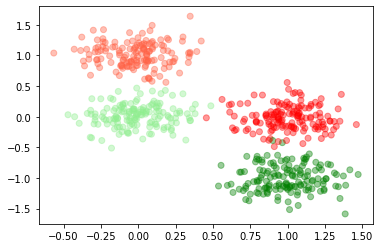

In [ ]:
Xs, ys = make_blobs(300, centers=[[0, 0], [0, 1]], cluster_std=0.2)
Xt, yt = make_blobs(300, centers=[[1, -1], [1, 0]], cluster_std=0.2)

plt.scatter(Xs[:,0], Xs[:,1], c=[["lightgreen", "tomato"][k] for k in ys], alpha=0.4)
plt.scatter(Xt[:,0], Xt[:,1], c=[["g", "red"][k] for k in yt],  alpha=0.4)

As you know, DANN doesn't have access to target dataset labels. 

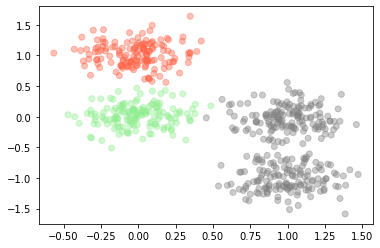

In [ ]:
plt.scatter(Xs[:,0], Xs[:,1], c=[["lightgreen", "tomato"][k] for k in ys], alpha=0.4)
plt.scatter(Xt[:,0], Xt[:,1], c=[["gray", "gray"][k] for k in yt],  alpha=0.4)


## building the DANN model

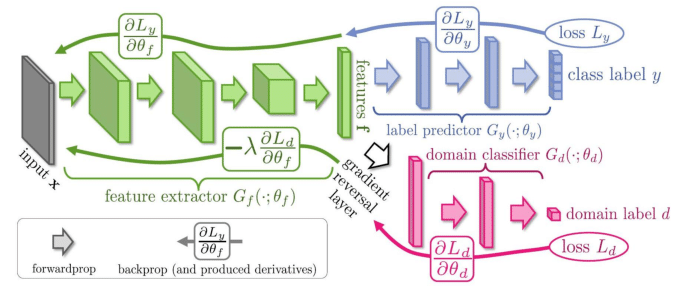

In [ ]:
def build_models(n_neurons, nn_dim=2):
    """Creates three different models, one used for source only training, two used for domain adaptation"""
    
    ## feature extractor
    inputs = Input(shape=(nn_dim,))
    x4 = Dense(n_neurons, activation='linear')(inputs)
    x4 = BatchNormalization()(x4)
    x4 = Activation("elu")(x4)

    ## Class label predictor
    source_classifier = Dense(2, activation='softmax', name="mo")(x4) ## NOTE: the number of class labels are hardcoded here!

    ## Domain classifier
    domain_classifier = Dense(32, activation='linear', name="do4")(x4)
    domain_classifier = BatchNormalization(name="do5")(domain_classifier)
    domain_classifier = Activation("elu", name="do6")(domain_classifier)
    domain_classifier = Dropout(0.5)(domain_classifier)
    domain_classifier = Dense(2, activation='softmax', name="do")(domain_classifier) ## NOTE: the number of domains are hardcoded as well

    ## compiling the model and defining loss fuctions
    comb_model = Model(inputs=inputs, outputs=[source_classifier, domain_classifier])
    comb_model.compile(optimizer="Adam",
                       loss={'mo': 'categorical_crossentropy', 'do': 'categorical_crossentropy'},
                       loss_weights={'mo': 1, 'do': 2}, metrics=['accuracy'], )

    source_classification_model = Model(inputs=inputs, outputs=[source_classifier])
    source_classification_model.compile(optimizer="Adam",
                                        loss={'mo': 'categorical_crossentropy'}, metrics=['accuracy'], )

    domain_classification_model = Model(inputs=inputs, outputs=[domain_classifier])
    domain_classification_model.compile(optimizer="Adam",
                                        loss={'do': 'categorical_crossentropy'}, metrics=['accuracy'])

    embeddings_model = Model(inputs=inputs, outputs=[x4])
    embeddings_model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])

    return comb_model, source_classification_model, domain_classification_model, embeddings_model


def batch_generator(data, batch_size):
    """
    Generate batches of data.
    Given a list of numpy data, it iterates over the list and returns batches of the same size
    """
    all_examples_indices = len(data[0])
    while True:
        mini_batch_indices = np.random.choice(all_examples_indices, size=batch_size, replace=False)
        tbr = [k[mini_batch_indices] for k in data]
        yield tbr


Train function takes source and target information and train the network. Target labels are not used for training.

In [ ]:
def train(Xs, ys, Xt, yt, enable_dann=True, n_input_dim=2, n_iterations=15000):

    batch_size = 64
    model, source_classification_model, domain_classification_model, embeddings_model = build_models(2, nn_dim=n_input_dim)

    y_class_dummy = np.ones((len(Xt), 2))
    y_adversarial_1 = to_categorical(np.array(([1] * batch_size + [0] * batch_size)))

    sample_weights_class = np.array(([1] * batch_size + [0] * batch_size))
    sample_weights_adversarial = np.ones((batch_size * 2,))

    S_batches = batch_generator([Xs, to_categorical(ys)], batch_size)
    T_batches = batch_generator([Xt, np.zeros(shape=(len(Xt), 2))], batch_size)

    for i in range(n_iterations):
        # # print(y_class_dummy.shape, ys.shape)
        y_adversarial_2 = to_categorical(np.array(([0] * batch_size + [1] * batch_size)))

        X0, y0 = next(S_batches)
        X1, y1 = next(T_batches)

        X_adv = np.concatenate([X0, X1])
        y_class = np.concatenate([y0, np.zeros_like(y0)])

        adv_weights = []
        for layer in model.layers:
            if (layer.name.startswith("do")):
                adv_weights.append(layer.get_weights())

        if (enable_dann):
            # note - even though we save and append weights, the batchnorms moving means and variances
            # are not saved throught this mechanism
            stats = model.train_on_batch(X_adv, [y_class, y_adversarial_1],
                                         sample_weight=[sample_weights_class, sample_weights_adversarial])

            k = 0
            for layer in model.layers:
                if (layer.name.startswith("do")):
                    layer.set_weights(adv_weights[k])
                    k += 1

            class_weights = []

            for layer in model.layers:
                if (not layer.name.startswith("do")):
                    class_weights.append(layer.get_weights())

            stats2 = domain_classification_model.train_on_batch(X_adv, y_adversarial_2)

            k = 0
            for layer in model.layers:
                if (not layer.name.startswith("do")):
                    layer.set_weights(class_weights[k])
                    k += 1

        else:
            source_classification_model.train_on_batch(X0, y0)

        if ((i + 1) % 1000 == 0):
            # print(i, stats)
            y_test_hat_t = source_classification_model.predict(Xt).argmax(1)
            y_test_hat_s = source_classification_model.predict(Xs).argmax(1)
            print("Iteration %d, source accuracy =  %.3f, target accuracy = %.3f" % (
            i, accuracy_score(ys, y_test_hat_s), accuracy_score(yt, y_test_hat_t)))
    return embeddings_model



**Training the class predictor only - without domain adaptation**

In [ ]:
embs = train(Xs, ys, Xt, yt, enable_dann = False, n_input_dim=2)

print(Xs.shape)
print(Xt.shape)


Iteration 999, source accuracy =  0.997, target accuracy = 0.500
Iteration 1999, source accuracy =  1.000, target accuracy = 0.500
Iteration 2999, source accuracy =  1.000, target accuracy = 0.500
Iteration 3999, source accuracy =  1.000, target accuracy = 0.503
Iteration 4999, source accuracy =  1.000, target accuracy = 0.503
Iteration 5999, source accuracy =  1.000, target accuracy = 0.503
Iteration 6999, source accuracy =  1.000, target accuracy = 0.503
Iteration 7999, source accuracy =  1.000, target accuracy = 0.503
Iteration 8999, source accuracy =  1.000, target accuracy = 0.507
Iteration 9999, source accuracy =  1.000, target accuracy = 0.507
Iteration 10999, source accuracy =  1.000, target accuracy = 0.507
Iteration 11999, source accuracy =  1.000, target accuracy = 0.507
Iteration 12999, source accuracy =  1.000, target accuracy = 0.507
Iteration 13999, source accuracy =  1.000, target accuracy = 0.507
Iteration 14999, source accuracy =  1.000, target accuracy = 0.507
(300, 

Visualising the top layer of the feature extractor
* How alignments of different classes look like?

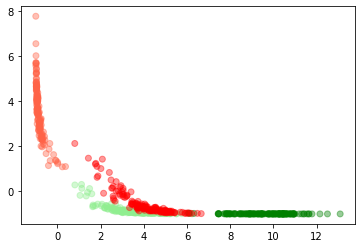

In [ ]:
Xs_act = embs.predict(Xs)
Xt_act = embs.predict(Xt)

plt.scatter(Xs_act[:,0], Xs_act[:,1], c=[["lightgreen", "tomato"][k] for k in ys], alpha=0.4)
plt.scatter(Xt_act[:,0], Xt_act[:,1], c=[["g", "red"][k] for k in yt],  alpha=0.4)

**Training DANN - including domain adaptation**

In [ ]:
embs = train(Xs, ys, Xt, yt, enable_dann = True, n_input_dim=2)

print(Xs.shape)
print(Xt.shape)


Iteration 999, source accuracy =  0.973, target accuracy = 0.957
Iteration 1999, source accuracy =  0.970, target accuracy = 0.960
Iteration 2999, source accuracy =  0.970, target accuracy = 0.960
Iteration 3999, source accuracy =  0.973, target accuracy = 0.960
Iteration 4999, source accuracy =  0.970, target accuracy = 0.960
Iteration 5999, source accuracy =  0.963, target accuracy = 0.953
Iteration 6999, source accuracy =  0.973, target accuracy = 0.957
Iteration 7999, source accuracy =  0.973, target accuracy = 0.957
Iteration 8999, source accuracy =  0.973, target accuracy = 0.957
Iteration 9999, source accuracy =  0.973, target accuracy = 0.953
Iteration 10999, source accuracy =  0.973, target accuracy = 0.957
Iteration 11999, source accuracy =  0.977, target accuracy = 0.953
Iteration 12999, source accuracy =  0.973, target accuracy = 0.957
Iteration 13999, source accuracy =  0.973, target accuracy = 0.960
Iteration 14999, source accuracy =  0.970, target accuracy = 0.957
(300, 

Visualising the top layer of the feature extractor.

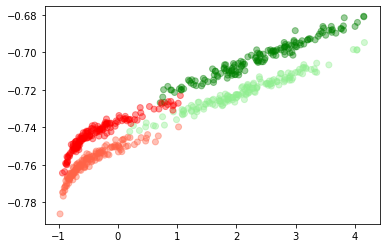

In [ ]:
Xs_act = embs.predict(Xs)
Xt_act = embs.predict(Xt)

plt.scatter(Xs_act[:,0], Xs_act[:,1], c=[["lightgreen", "tomato"][k] for k in ys], alpha=0.4)
plt.scatter(Xt_act[:,0], Xt_act[:,1], c=[["g", "red"][k] for k in yt],  alpha=0.4)

## DANN for turbofan engine data

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# loading the souce and target data
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id_train1 = '1EvNPwZ6WW_TmiddL_dERnr-aaVllLV_C'
downloaded = drive.CreateFile({'id': file_id_train1})
downloaded.GetContentFile('fd1_train.csv')
print(os.listdir())
df_source=pd.read_csv('fd1_train.csv')

file_id_train4 = '1LXwdo7VlBLk_akoXnMaZB_nB_FOXVWu6'
downloaded = drive.CreateFile({'id': file_id_train4})
downloaded.GetContentFile('fd4_train.csv')
print(os.listdir())
df_target=pd.read_csv('fd4_train.csv')

nn_dim = 26

['.config', 'fd1_train.csv', 'adc.json', 'sample_data']
['.config', 'fd1_train.csv', 'fd4_train.csv', 'adc.json', 'sample_data']


Although this dataset has RUL as target variable and usually formulated as regression task, we have converted the problem to a binary classification. So, if RUL is bigger than 50 we assume the engine is healthy and otherwise faulty. 

In [ ]:
# binary classification problem

df_source.loc[df_source["rul"] <=50, "rul"] = 1
df_source.loc[df_source["rul"] >50, "rul"] = 0
df_target.loc[df_target["rul"] <=50, "rul"] = 1
df_target.loc[df_target["rul"] >50, "rul"] = 0


preparing source and target training and test sets

In [ ]:
source_units = random.sample(list(df_source["id"].unique()), 40)
source_units_train = source_units[:20]
source_units_test = source_units[-20:]
target_units = random.sample(list(df_target["id"].unique()), 20)

print("selected source units", source_units)
print("selected target units", target_units)

x_var = [xx for xx in df_source.columns if xx != "rul"] 
target_var = "rul"
print(x_var)
print(target_var)


selected source units [70, 26, 7, 53, 67, 3, 55, 56, 87, 66, 64, 60, 97, 63, 50, 100, 47, 84, 71, 85, 32, 77, 16, 65, 12, 72, 74, 20, 18, 69, 27, 94, 48, 52, 83, 25, 37, 15, 40, 61]
selected target units [98, 34, 45, 73, 240, 102, 222, 175, 177, 7, 169, 123, 133, 115, 76, 219, 13, 162, 247, 189]
['id', 'cycle', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24']
rul


In [ ]:
Xs = df_source[df_source["id"].isin(source_units_train)][x_var].to_numpy()
Xs_test = df_source[df_source["id"].isin(source_units_test)][x_var].to_numpy()
Xt = df_target[df_target["id"].isin(target_units)][x_var].to_numpy()

ys = df_source[df_source["id"].isin(source_units_train)][target_var].to_numpy()
ys_test = df_source[df_source["id"].isin(source_units_test)][target_var].to_numpy()
yt = df_target[df_target["id"].isin(target_units)][target_var].to_numpy()


**Training the class predictor only - without domain adaptation**

In [ ]:
embs = train(Xs, ys, Xt, yt, enable_dann = False, n_input_dim=26, n_iterations=5000)

Iteration 999, source accuracy =  0.759, target accuracy = 0.479
Iteration 1999, source accuracy =  0.241, target accuracy = 0.306
Iteration 2999, source accuracy =  0.759, target accuracy = 0.388
Iteration 3999, source accuracy =  0.759, target accuracy = 0.384
Iteration 4999, source accuracy =  0.330, target accuracy = 0.326


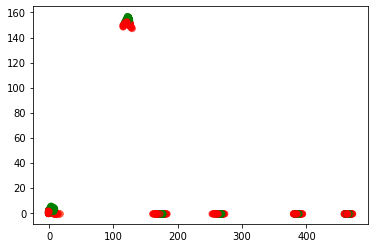

In [ ]:
Xs_act = embs.predict(Xs)
Xt_act = embs.predict(Xt)


plt.scatter(Xs_act[:,0], Xs_act[:,1], c=[["lightgreen", "tomato"][int(k)] for k in ys], alpha=0.4)
plt.scatter(Xt_act[:,0], Xt_act[:,1], c=[["g", "red"][int(k)] for k in yt],  alpha=0.4)



**Training DANN - including domain adaptation**

In [ ]:
embs = train(Xs, ys, Xt, yt, enable_dann = True, n_input_dim=26, n_iterations=5000)

Iteration 999, source accuracy =  0.759, target accuracy = 0.774
Iteration 1999, source accuracy =  0.798, target accuracy = 0.767
Iteration 2999, source accuracy =  0.759, target accuracy = 0.779
Iteration 3999, source accuracy =  0.807, target accuracy = 0.780


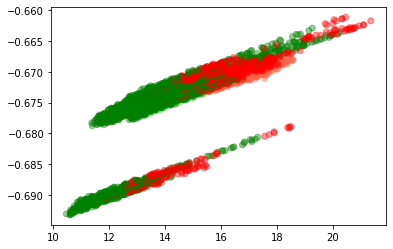

In [ ]:
Xs_act = embs.predict(Xs)
Xt_act = embs.predict(Xt)


plt.scatter(Xs_act[:,0], Xs_act[:,1], c=[["lightgreen", "tomato"][int(k)] for k in ys], alpha=0.4)
plt.scatter(Xt_act[:,0], Xt_act[:,1], c=[["g", "red"][int(k)] for k in yt],  alpha=0.4)



# References
* Yaroslav Ganin, Evgeniya Ustinova, Hana Ajakan, Pascal Germain, Hugo Larochelle, François Laviolette, Mario Marchand, Victor Lempitsky.
Domain-Adversarial Training of Neural Networks. Journal of Machine Learning Research, 2016. http://jmlr.org/papers/v17/15-239.html
* github version by authers of the paper: https://github.com/ddtm/caffe/tree/grl
